###Value at risk (VaR)
Estimating the risk of a portfolio is very important to long-term capital growth. There are a lot of techniques to help manage risk, but here we'll be covering 'value at risk' (VaR).

There are two main ways to calculate VaR:

1. Using Monte Carlo simulation
2. Using the Variance-Covariance method.

In this post, we'll focus on using method 2 (variance-covariance).

VaR provides an estimate of the maximum loss from a given portfolio over a period of time. You can calculate VaR at various confidence levels.

For example, given a VaR of 250,000 at 95% confidence, there is a 95% chance that your portfolio will lose no more than 250,000 the following day.

Note that the standard VaR calculation assumes the following:

Normal distribution of returns - VaR assumes the returns of the portfolio are normally distributed. This is of course not realistic for most assets, but allows us to develop a baseline using a much more simplistic calculation. (Modifications can be made to VaR to account for different distributions, but here we'll focus on the standard VaR calculation).

Standard market conditions - Like many financial instruments, VaR is best used for considering loss in standard markets, and is not well-suited for extreme/outlier events.

Steps to calculate the VaR of a portfolio
In order to calculate the VaR of your portfolio, you can follow the steps below:

1. Calculate periodic returns of the stocks in your portfolio
2. Create a covariance matrix based on the returns
3. Calculate the portfolio mean and standard deviation 
(weighted based on investment levels of each stock in portolio)
4. Calculate the inverse of the normal cumulative distribution (PPF) with a specified confidence interval standard deviation, and mean
5. Estimate the value at risk (VaR) for the portfolio by subtracting the initial investment from the calculation in step 4

In [21]:
import pandas as pd
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
    
#Create our portfolio of equities
tickers = ['AAPL','FB', 'C', 'DIS']
 
#Set the investment weights (I arbitrarily picked for example)
weights = np.array([.25, .3, .15, .3])
 
#Set an initial investment level
initial_investment = 1000000
 
#Download closing prices
data = pdr.get_data_yahoo(tickers, start="2021-01-01", end=dt.date.today())['Close']
 
#From the closing prices, calculate periodic returns
returns = data.pct_change()

In [22]:
print(data)

Symbols           AAPL          FB          C         DIS
Date                                                     
2021-01-04  129.410004         NaN  60.139999  177.679993
2021-01-05  131.009995         NaN  61.700001  178.440002
2021-01-06  126.599998         NaN  65.250000  179.119995
2021-01-07  130.919998         NaN  66.019997  178.580002
2021-01-08  132.050003         NaN  65.370003  178.690002
...                ...         ...        ...         ...
2022-09-08  154.460007  162.059998  49.900002  112.330002
2022-09-09  157.369995  169.149994  50.669998  115.180000
2022-09-12  163.429993  168.960007  50.869999  116.389999
2022-09-13  153.839996  153.130005  49.000000  111.760002
2022-09-14  155.228104  151.729996  48.471401  112.669998

[428 rows x 4 columns]


<h4>2) Create a covariance matrix based on the returns </h4>


In [23]:
#Generate Var-Cov matrix
cov_matrix = returns.cov()
cov_matrix


Symbols,AAPL,FB,C,DIS
Symbols,,,,
AAPL,0.000336,0.000409,0.000112,0.000149
FB,0.000409,0.001219,0.000276,0.000401
C,0.000112,0.000276,0.000353,0.000177
DIS,0.000149,0.000401,0.000177,0.000328


<h4>3) Calculate the portfolio mean and standard deviation</h4>

In [24]:
#Calculate mean returns for each stock
avg_rets = returns.mean()
 
#Calculate mean returns for portfolio overall, 
#using mean, using dot product formula to 
#normalize against investment weights
port_mean = avg_rets.dot(weights)
 
#Calculate portfolio standard deviation
port_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))
 
#Calculate mean of given investment
mean_investment = (1+port_mean) * initial_investment
             
#Calculate standard deviation of given investmnet
stdev_investment = initial_investment * port_stdev

<h4>4) Calculate the inverse of the normal cumulative distribution (PPF) with a specified confidence interval, standard deviation, and mean</h4>

In [25]:
#Select our confidence interval (I'll choose 95% here)
conf_level1 = 0.05

#Using SciPy ppf method to generate values for the
#inverse cumulative distribution function to a normal distribution
#Plugging in the mean, standard deviation of our portfolio
#as calculated above
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
from scipy.stats import norm
cutoff1 = norm.ppf(conf_level1, mean_investment, stdev_investment)


5) Estimate the value at risk (VaR) for the portfolio by subtracting the initial investment from the calculation in step 4

In [26]:
#Finally, we can calculate the VaR at our confidence interval
var_1d1 = initial_investment - cutoff1
var_1d1

32843.055439102114

<p>Here we are saying with 95% confidence that the loss of our portfolio will not exceed ~$32.8k over a one day period.</p>
<h4>Value at risk over n-day time period</h4>
<p>What if we wanted to calculate this over a larger window of time? Below we can easily do that by just taking our 1 day VaR and multiplying it by the <a href="https://www.investopedia.com/articles/04/101304.asp" target="_blank">square root of the time period</a>.</p>

1 day VaR @ 95% confidence: 32843.06
2 day VaR @ 95% confidence: 46447.09
3 day VaR @ 95% confidence: 56885.84
4 day VaR @ 95% confidence: 65686.11
5 day VaR @ 95% confidence: 73439.3
6 day VaR @ 95% confidence: 80448.73
7 day VaR @ 95% confidence: 86894.56
8 day VaR @ 95% confidence: 92894.19
9 day VaR @ 95% confidence: 98529.17
10 day VaR @ 95% confidence: 103858.86
11 day VaR @ 95% confidence: 108928.09
12 day VaR @ 95% confidence: 113771.68
13 day VaR @ 95% confidence: 118417.32
14 day VaR @ 95% confidence: 122887.46
15 day VaR @ 95% confidence: 127200.61


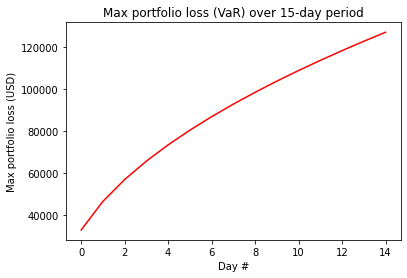

In [27]:
# Calculate n Day VaR
var_array = []
num_days = int(15)
for x in range(1, num_days+1):    
    var_array.append(np.round(var_1d1 * np.sqrt(x),2))
    print(str(x) + " day VaR @ 95% confidence: " + str(np.round(var_1d1 * np.sqrt(x),2)))

# Build plot
plt.xlabel("Day #")
plt.ylabel("Max portfolio loss (USD)")
plt.title("Max portfolio loss (VaR) over 15-day period")
plt.plot(var_array, "r")


Checking distributions of our equities against normal distribution


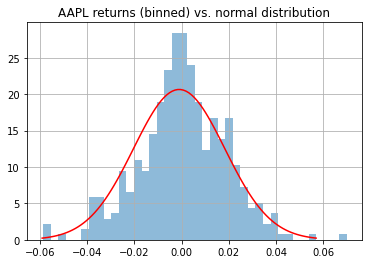

In [28]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy

returns['AAPL'].hist(bins=40, density=True,histtype="stepfilled",alpha=0.5)
x = np.linspace(port_mean - 3*port_stdev, port_mean+3*port_stdev,100)
plt.plot(x, scipy.stats.norm.pdf(x, port_mean, port_stdev), "r")
plt.title("AAPL returns (binned) vs. normal distribution")
plt.show()

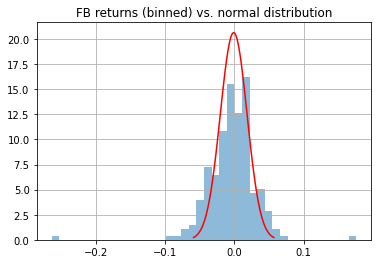

In [29]:
returns['FB'].hist(bins=40, density=True,histtype="stepfilled",alpha=0.5)
x = np.linspace(port_mean - 3*port_stdev, port_mean+3*port_stdev,100)
plt.plot(x, scipy.stats.norm.pdf(x, port_mean, port_stdev), "r")
plt.title("FB returns (binned) vs. normal distribution")
plt.show()

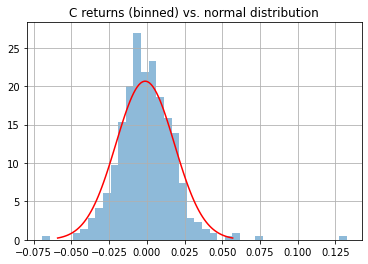

In [30]:
returns['C'].hist(bins=40, density=True,histtype="stepfilled",alpha=0.5)
x = np.linspace(port_mean - 3*port_stdev, port_mean+3*port_stdev,100)
plt.plot(x, scipy.stats.norm.pdf(x, port_mean, port_stdev), "r")
plt.title("C returns (binned) vs. normal distribution")
plt.show()


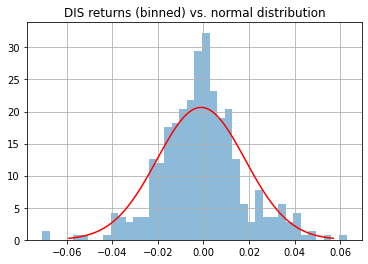

In [31]:
returns['DIS'].hist(bins=40, density=True,histtype="stepfilled",alpha=0.5)
x = np.linspace(port_mean - 3*port_stdev, port_mean+3*port_stdev,100)
plt.plot(x, scipy.stats.norm.pdf(x, port_mean, port_stdev), "r")
plt.title("DIS returns (binned) vs. normal distribution")
plt.show()